# Máquinas de Soporte Vectorial

## Instalar las librerias faltantes

In [83]:
%%capture
# !pip install emoji
# !pip install unidecode
# !pip install contractions

## Importar librerias necesarias

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import contractions
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


# Download NLTK's resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize SnowballStemmer
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Leemos los datos

In [85]:
data = pd.read_csv('data/data_comb.csv', index_col = 0)

Nos vamos a quedar con un pequeño porcetage de los datos porque son muchos

In [86]:
data = data.sample(frac=0.30, random_state = 42)

Quitaremos las etiquetas de desorden de personalidad, estrés, ansiedad y bipolaridad

In [87]:
data = data[~data['status'].isin(['Personality disorder', 'Stress', 'Anxiety', 'Bipolar'])]

Visualizamos los datos para saber con qué estamos trabajando

In [88]:
data.head()

,statement,status
22261,Just as the the title says. I feel like one is...,Depression
41400,a blackened sky encroached tugging behind it m...,Depression
20065,"It gives you insomnia, which in turn makes you...",Depression
30036,"Hello all, I'm a new submitter to this channel...",Normal
780,Thank God the CB is over for Eid,Normal


In [106]:
for msg in data.head()['statement']:
    print(msg)

Just as the the title says. I feel like one is hyper alot, a attention whore, and is idealistic and stupid. and the other is calm, trys to be normal, is a realist, and wants to kill the other one, witch is why I somtimes choke myself, usually for at most 30 seconds at a time just so the other can stop controlling me and make me look like an idiot. And I am not insane, its not like there telling me to hurt others, So can some please tell me, is this normal? Am I depressed? Or is it some other mental disease. Thanks I feel like there is 2 of me and one of them hates the other
a blackened sky encroached tugging behind it my depression
It gives you insomnia, which in turn makes your depression worse during the day, which messes up your sleep even more, which gives you anxiety. It just feels impossible to function. what is even worse is when I cannot sleep, my symptoms of my ocd and anxiety are just 50x worse. It feels impossible to escape depressuon
Hello all, I'm a new submitter to this c

In [89]:
data = data.dropna()

Dividimos los datos en entrenamiento y evaluación

In [90]:
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(
    data.drop('status', axis = 1), list(data['status']),
    stratify = list(data['status']),
    test_size=0.20,
    random_state=42
    )


# Preprocesamiento

## Representación

Definiremos la función **preprocess_text** para realizar el preprocesamiento necesario a las bases de datos.

La función consiste de lo siguiente:
1. Eliminar los nombres de usuario, enlaces y símbolos de hashtag
2. Conversión de Unicode a ASCII
3. Tokenización
4. Filtrado de palabras comunes

## Ejemplo alegre en imagen de eliminación de stopwords, tokenización y stemming

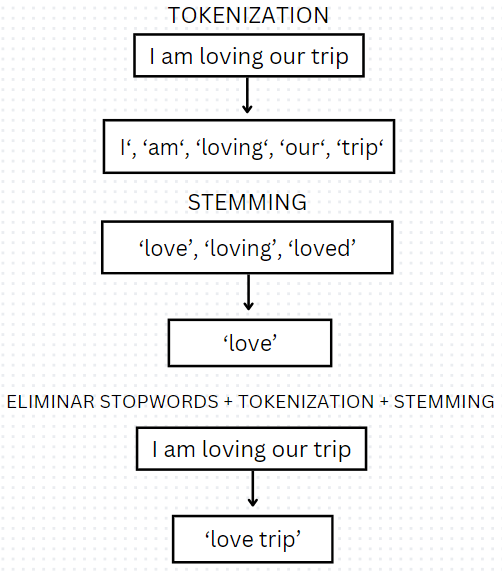

In [91]:
# Define the preprocess_text function

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()

    text = re.sub(r'@[^\s]+', '', text)
    # Remove links starting with http or https
    text = re.sub(r'https?://\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#', '', text)

    text_aux = ''
    for word in text.split():
        text_aux += contractions.fix(word.lower()) + ' '

    # Convert Unicode to ASCII
    text = unidecode(text_aux.strip())
    # Remove stopwords and stem words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    # print(filtered_text)
    stemmed_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    # print(stemmed_text)
    # Tokenize text
    tokens = nltk.word_tokenize(' '.join(stemmed_text))
    # print(tokens)
    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # print(cleaned_tokens)
    cleaned_tokens = [token for token in cleaned_tokens if token]  # Remove empty tokens
    # print(cleaned_tokens)
    cleaned_tokens = [token for token in cleaned_tokens if token not in ['th']]
    return ' '.join(cleaned_tokens)

In [92]:
X_data_train['clean_statement'] = X_data_train['statement'].apply(preprocess_text)
X_data_test['clean_statement'] = X_data_test['statement'].apply(preprocess_text)

## Encoding

Ahora procederemos a vectorizar las oraciones con TF-IDF y codificar las etiquetas con LabelEncoder.

La frecuencia del término (TF) de una palabra es la cantidad de veces que aparece en un documento en comparación con la cantidad total de palabras en el documento. Por ejemplo, supongamos que en un documento de 100 palabras la palabra 'depress' aparece 20 veces, el TF sería, 20/100 = 0.2

Por otro lado, la frecuencia inversa de documentos (IDF) de un término refleja la proporción de documentos en el corpus que contienen la palabra, en el IDF la transformación logarítmica se utiliza para escalar los valores para que estén distribuidos de manera más uniforme y sea más fácil trabajar con ellos en tareas posteriores de aprendizaje automático. Por ejemplo, asumiendo que el corpus se compone de 10,000 documentos y la palabra 'depress' aparece en 100 de ellos, su IDF sería, log(10000/100) = 2

Por último, el TF-IDF de una palabra se calcula multiplicando las puntuaciones TF e IDF; utilizando el ejemplo dado, quedaría, 0.2*2 = 0.4, indicando que tiene una importancia moderada. Mientras más alto sea la puntuación del TF-IDF, mayor importancia o relevancia tiene la palabra.

Aplicando todo lo anterior descrito, se crea un vector numerico para cada documento, que en este caso sería para cada tweet. Para más información de TF-IDF y su implementación en Python, ver el siguiente link: https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

In [93]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_data_train["clean_statement"].tolist())
X_test = vectorizer.transform(X_data_test["clean_statement"].tolist())

In [94]:
# Type of matrix created by vectorizer and its shape
print(type(X_train), X_train.shape)

<class 'scipy.sparse._csr.csr_matrix'> (10160, 24206)


In [95]:
# Sparse matrix created by the vectorizer in X_train
sparse_matrix = X_train.toarray()

sparse_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Veamos las palabras resultantes del primer tweet y sus valores TF-IDF con el TfidfVectorizer()

In [96]:
# Find the indices of non-zero elements in the first row (tweet)
non_zero_indices = sparse_matrix[:1].nonzero()

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Print the non-zero values and their words
for row, col in zip(non_zero_indices[0], non_zero_indices[1]):
    value = sparse_matrix[row, col]
    word = feature_names[col]
    print(f"Word: {word}, Value: {round(value,2)}")

Word: acceptance, Value: 0.41
Word: anger, Value: 0.31
Word: bargaining, Value: 0.51
Word: denial, Value: 0.41
Word: depression, Value: 0.17
Word: grief, Value: 0.37
Word: stage, Value: 0.37


In [97]:
# Comparison of original tweet with preprocessed one
print(list(X_data_train['statement'])[0], '--->', list(X_data_train['clean_statement'])[0])

there is stage of grief denial anger bargaining depression and acceptance ---> stage grief denial anger bargaining depression acceptance


## Label encoding

Para alimentar los datos al modelo, es necesario preprocesar los tweets como ya se hizo, y también las etiquetas.

La codificación de etiquetas se logró mediante el uso de un codificador de etiquetas numérico para asignar a cada clase de emoción un número único.

Abajo notaremos que se les dió este orden a las etiquetas ['Depression', 'Normal', 'Suicidal']. Sin embargo, el etiquetado se realiza alfabéticamente, por eso 0 es 'Depression', 1 es 'Normal', etc.

In [98]:
# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
label_encoder.fit(['Depression', 'Normal', 'Suicidal'])
y_train_encoded = label_encoder.transform(y_data_train)
y_test_encoded = label_encoder.transform(y_data_test)

In [99]:
# Numeric labels
np.unique(y_train_encoded)

array([0, 1, 2])

In [100]:
# Original labels
np.unique(label_encoder.inverse_transform(y_train_encoded))

array(['Depression', 'Normal', 'Suicidal'], dtype='<U10')

In [101]:
# Best parameters obtained from grid search
params = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

# Create SVM model with best parameters
svm_model = SVC(C=params['C'], gamma=params['gamma'], kernel=params['kernel'])

# Train the SVM model
svm_model.fit(X_train, y_train_encoded)

# Evaluate the model
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

  Depression       0.74      0.77      0.75       922
      Normal       0.88      0.95      0.91       998
    Suicidal       0.69      0.57      0.62       621

    accuracy                           0.79      2541
   macro avg       0.77      0.76      0.76      2541
weighted avg       0.78      0.79      0.78      2541



## Confusion matrix

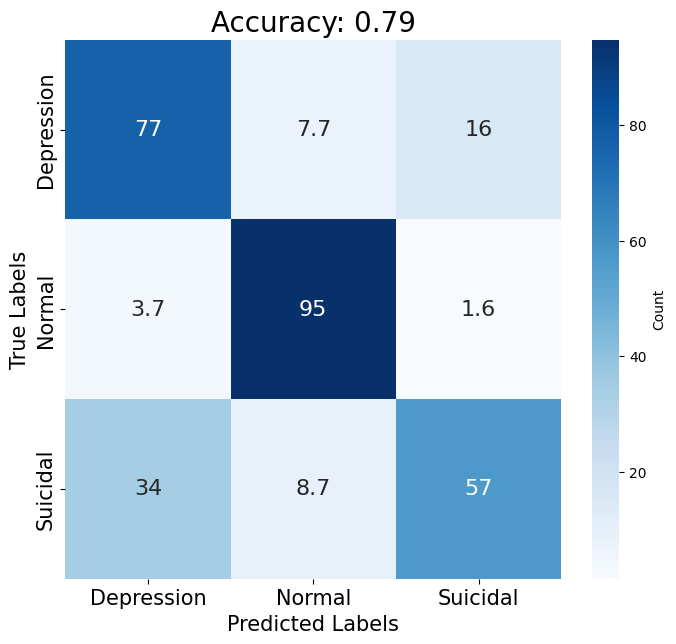

In [102]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
percentage_conf_matrix = np.round(normalized_conf_matrix * 100, 2)
# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(percentage_conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot_kws={"size": 16}, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
plt.title(f'Accuracy: {round(accuracy_score(y_test_encoded, y_pred), 2)}', fontsize=20)

# Adjust tick label font sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [103]:
preds = pd.DataFrame(zip(y_test_encoded, y_pred, X_data_test['statement']), columns = ['true', 'pred', 'msg'])

In [104]:
bad_preds = preds[(preds['true'] == 2) & (preds['pred'] == 1)]

In [105]:
for msg in bad_preds.sample(10, random_state = 42)['msg']:
    print(msg)
    print()

That is all. 1 more month.

If you want you could write it down with a bit of ink from a quill. No one will even notice, when you or I start to lose focus. you are lying to yourself if you think you are valued more than a locust. I am mentally ill and I should let the blood spill.

The need for cuddles, but you know you are ugly, what do you do honestly dying actually does not sound half bad Any label for my problem?

@janakidasa1 @BeecheyPat @central_cap @LevequeThots It is sickening. What is sickening is we elect ppl like the libâ¦ https://t.co/v8PzGBUglY

Can eating shoe polish lead to death ? Question

It should not be this easy to get a gun in Florida lol. cannot say I am surprised. It is Florida after all. Big yikes for me though Yikes

He:I knew that even if I reached my dream, it could not be everything. I love you. I was sick that we could get tirâ¦ https://t.co/Vg9o3u1JZh

@homerunderbyemo,,Just checked out that Homerun Derby EP, it SLAPS  https://t.co/lrHB1FDz6t

I realize

## Regresión


In [109]:
data = pd.read_csv('data/data_linear.csv')

In [111]:
y = list(data['label'])
X = data[['x', 'y']].to_numpy()

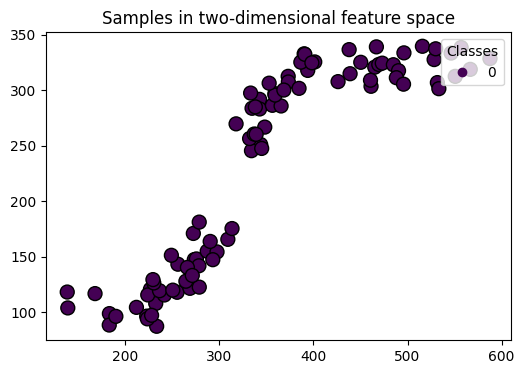

In [114]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(X[:, 0], X[:, 1], s=100, c=y, label=y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Samples in two-dimensional feature space")
_ = plt.show()

In [115]:
shuffled_df = data.sample(frac=1).reset_index(drop=True)
train = shuffled_df.head(140)
test = shuffled_df.tail(47)

In [117]:
reg = LinearRegression().fit(train['x'].to_numpy().reshape(-1, 1), train['y'].to_numpy().reshape(-1, 1))
pred = reg.predict(test['x'].to_numpy().reshape(-1, 1))

In [144]:
model = SVR(kernel = 'linear', C = 10)
model.fit(train['x'].to_numpy().reshape(-1, 1), train['y'])

SVR(C=10, kernel='linear')

In [142]:
model2 = SVR(kernel = 'poly', degree = 3, C = 5)
model2.fit(train['x'].to_numpy().reshape(-1, 1), train['y'])

SVR(C=5, kernel='poly')

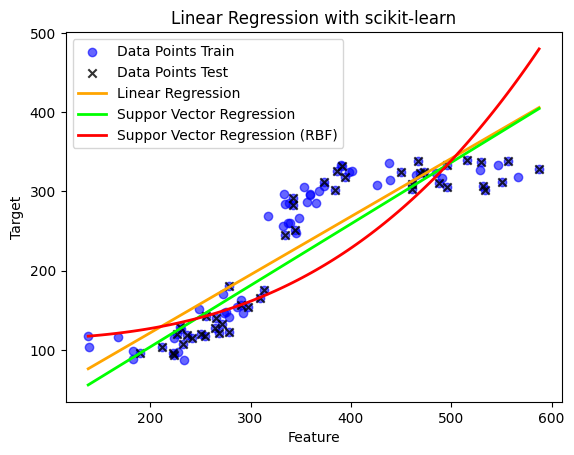

In [145]:
plt.scatter(train['x'], train['y'], color='blue', label='Data Points Train', alpha=0.6)

plt.scatter(test['x'], test['y'], color='black',  marker = 'x', label='Data Points Test', alpha=0.8)

X_line = np.linspace(train['x'].min(), train['x'].max(), 100).reshape(-1, 1)
y_line = model.predict(X_line)
y_line2 = reg.predict(X_line)
y_line3 = model2.predict(X_line)
# Plot the regression line
plt.plot(X_line, y_line2, color='orange', linewidth=2, label='Linear Regression')
plt.plot(X_line, y_line, color='lime', linewidth=2, label='Suppor Vector Regression')
plt.plot(X_line, y_line3, color='red', linewidth=2, label='Suppor Vector Regression (RBF)')

# Add titles and labels
plt.title('Linear Regression with scikit-learn')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()

# Show the plot
plt.show()